In [1]:
import numpy as np
from qiskit import QuantumCircuit

from helper import *
from qite import aer_sim as backend
from qite import log_qite_run

import time

# Real Hamiltonian in Z basis
For this case, we only need to consider Hamiltonian terms that contain odd number of Ys.

This changes the alist data structure so that it only stores the amplitudes for said Odd Y Pauli strings. for `nbits` qubits, a list of the odd Y pauli strings can be found with `helper.odd_y_pauli_strings(nbits)`.

In [2]:
def y_propogate(qc, alist):
    for t in range(len(alist)):
        active = alist[t][1]
        nbits = len(active)
        odd_y_paulis = odd_y_pauli_strings(nbits)
        for i in range(len(odd_y_paulis)):
            angle = np.real(alist[t][0][i])
            if np.abs(angle) > 1e-5:
                pauli_string_exp(qc, active, odd_y_paulis[i], angle)
#                 qc.barrier()

$\newcommand{\bra}[1]{\langle{#1}|}$
$\newcommand{\ket}[1]{|{#1}\rangle}$
If $\hat{H}$ is real in the Z basis, that means its of the form 
$$ \hat{H} = \sum_I \alpha_I \sigma_I + i\sum_J \alpha^\prime_J \sigma_J$$
where $I$ are the indices of Pauli strings with even number of $Y$s and $J$ with odd number of $Y$s, and  $\alpha_I, \alpha^\prime_J \in \mathbb{R}$.

Recall that $b_K = -2\mathrm{Im}[\bra{\psi}\sigma_K\ket{\Delta_0}]$, so
$$ b_K = -2\mathrm{Im}\left[ \left(\frac{1}{\sqrt{c}}-1\right)\frac{1}{d\beta} \bra{\psi}\sigma_K\ket{\psi} 
    - \frac{1}{\sqrt{c}} \left(
    \sum_I \alpha_I \bra{\psi}\sigma_K\sigma_I\ket{\psi} + i \sum_J \alpha^\prime_J \bra{\psi}\sigma_K\sigma_J\ket{\psi}
    \right)
\right] $$

Only for $K$ with odd $Y$s will this have an imaginary part and be non-zero.

So, we can reduce the dimensionality of the system of linear equations to solve only for the non-zero $b_K$s, so we only have to do tomography for $[\sigma_J \times \sigma_J]$ to build $S$, and then $[\sigma_J \times \sigma_I\in \hat{H}]$ for $b$.

In [3]:
def y_tomography(hm, alist, qbits, nbits, backend, shots=1024):
    nactive = len(qbits)
    odd_ys = odd_y_pauli_strings(nactive)
    nops = len(odd_ys)
    
    keys = []
    
    for j in hm[0]:
        if not(j in keys):
            keys.append(j)
    
    for i in odd_ys:
        for j in odd_ys:
            p,c = pauli_string_prod(i,j,nactive)
            if not (p in keys):
                keys.append(p)
        for j in hm[0]:
            p,c = pauli_string_prod(i,j,nactive)
            if not (p in keys):
                keys.append(p)
    
#     print(keys)
    sigma_expectation = {}
    for key in keys:
#         sigma_expectation[key] = 0.0j
        qc = QuantumCircuit(nbits, nbits)
        y_propogate(qc, alist)
        sigma_expectation[key],counts = measure(qc, key, qbits, backend, shots)
    
    return sigma_expectation

def y_update_alist(sigma_expectation, alist, db, delta, hm):
    nactive = len(hm[2])
    nterms = len(hm[0])
    
    odd_ys = odd_y_pauli_strings(nactive)
    nops = len(odd_ys)
    
    S = np.zeros([nops,nops],dtype=complex)
    for i in range(nops):
        for j in range(nops):
            p,c_ = pauli_string_prod(odd_ys[i], odd_ys[j], nactive)
#             if p not in sigma_expectation.keys():
#                 print('{}=={}*{} not in keys?'.format(p, odd_ys[i], odd_ys[j]))
#                 print(sigma_expectation.keys())
            S[i,j] = sigma_expectation[p] * c_
    
    b = np.zeros(nops, dtype=complex)
    c = 1
    
    for i in range(nterms):
        c -= 2*db*sigma_expectation[hm[0][i]]
    c = np.sqrt(c)
    
    
    for k in range(len(odd_ys)):
        # This part not needed since it will always be real
#         b[k] += (1/c - 1) * sigma_expectation[odd_ys[k]]
        for j in range(nterms):
            p,c_ = pauli_string_prod(odd_ys[k], hm[0][j], nactive)
            b[k] -= hm[1][j] * c_ * sigma_expectation[p] / c
    b = -2*np.imag(b)
    
    dalpha = np.eye(nops) * delta
    
    x = np.linalg.lstsq(2*np.real(S) + dalpha, -b, rcond=-1)[0]
    
    a_coefficients = -2*db*x
    
    alist.append([a_coefficients, hm[2]])
    
    return c

In [6]:
def y_measure_energy(alist, nbits, hm_list, backend, shots=1024):
    '''
    Measure the expected energy of the state evolved by alist, given the hm_list of the Hamiltonian
    '''
    Energy = 0
    
    # For each hm term
    for hm in hm_list:
        # For each pauli term in hm
        for j in range(len(hm[0])):
            qc = QuantumCircuit(nbits, nbits)
            # Get the state evolved from alist
            y_propogate(qc, alist)
            
            # Measure the expected value of the pauli term in this state
            expectation, counts = measure(qc, hm[0][j], hm[2], backend, num_shots=shots)
            
            # Add this with the relevant weight to the energy total
            Energy += hm[1][j] * expectation
    return Energy

def y_qite_step(alist, db, delta, nbits, hm_list, backend, shots=1024):
    '''
    performs one imaginary time step of size db in the QITE
    '''
    for hm in hm_list:
        # peform tomography on the active qubits in hm
        sigma_expectation = y_tomography(hm, alist, hm[2], nbits, backend, shots=1024)
        # obtain the next alist term corresponding to hm
        norm = y_update_alist(sigma_expectation, alist, db, delta, hm)
    return alist

def y_log_qite_run(db, delta, N, nbits, hm_list, alist, file_name='y_hm-alist'):
    logging = []
    logging.append(True)
    logging.append(db)
    logging.append(delta)
    logging.append(N)
    logging.append(nbits)
    logging.append(hm_list)
    logging.append(alist)
    
    np.save(file_name+'.npy',np.asarray(logging,dtype=object))

def y_qite(db, delta, N, nbits, hm_list, backend, shots=1024, details=False, log=False, log_file = 'y_hm-alist'):
    '''
    Performs the QITE algorithm with: 
        db: a time step,
        delta: a regularization,
        N: number of total iterations (time steps)
        nbits: number of qubits in the whole system
        hm_list: list of local terms in the Hamiltonian
        backend: the backend that the quantum circuit will run on
        shots: the number of shots for each circuit run
        details: flag to show details while the algorithm runs
    '''
    # stores the mean energy for each time step
    E = np.zeros(N+1,dtype=float)
    # stores the iteration times
    times = np.zeros(N+1,dtype=float)
    
    alist = []
    
    E[0] = y_measure_energy(alist, nbits, hm_list, backend, shots)
    
    start = 0
    end = 0
    if details:
        print('Starting QITE Loop')
    
    for i in range(1,N+1):
        if details:
            print('i={}:'.format(i), end='  ', flush=True)
            start = time.time()

        # correction_matrix = estimate_assignment_probs()
        alist = y_qite_step(alist, db, delta, nbits, hm_list, backend, shots)
        # Record the energy of the system after the QITE step
        E[i] = y_measure_energy(alist, nbits, hm_list, backend, shots)

        if details:
            end = time.time()
            duration = end-start
            times[i] = duration
            print('Execution time: {:.2f} seconds'.format(duration))

    if log:
        y_log_qite_run(db, delta, N, nbits, hm_list, alist, log_file)
    return E,times

In [7]:
# QITE Parameters
db = 0.05       # Size of imaginary time step
N = 30          # Number of imaginary time steps
shots = 5000    # Number of measurements taken for each circuit
delta = 0.1     # Regularizer value

# Hamiltonian Description
nbits = 2       # Number of qubits in the full system

hm_list = []
hm = [ [3+1*4], [np.sqrt(0.5)], [0,1] ]
hm_list.append(hm)
hm = [ [1,3], [0.5, 0.5], [1]]
hm_list.append(hm)

# print(hm_list)

from os import path, makedirs
import matplotlib.pyplot as plt
%matplotlib inline


log_path = './qite_logs/odd_y/shots=5000/'
fig_path = './figs/energies/odd_y/shots=5000/'
run_identifier = 'run001'

if not path.exists(log_path):
    makedirs(log_path)
if not path.exists(fig_path):
    makedirs(fig_path)

E,times = y_qite(db, delta, N, nbits, hm_list, backend, shots, details=True, log=True, log_file=log_path+run_identifier)

# alist = []
# E = np.zeros(N+1, dtype=complex)
# E[0] = y_measure_energy(alist, nbits, hm_list, backend, shots)
# times = np.zeros(N+1, dtype=float)

# start = 0
# end = 0
# print('Starting QITE Loop')
# for i in range(1,2):
#     start = time.time()
#     print('i = ', i)#, end=' ',flush=True)
    
#     # qite step
#     for hm in hm_list:
#         sigma_expectation = y_tomography(hm, alist, hm[2], nbits, backend, shots)
#         print(sigma_expectation)
#         norm = y_update_alist(sigma_expectation, alist, db, delta, hm)

Starting QITE Loop
i=1:  Execution time: 0.68 seconds
i=2:  Execution time: 1.62 seconds
i=3:  Execution time: 2.59 seconds
i=4:  Execution time: 3.78 seconds
i=5:  Execution time: 4.20 seconds
i=6:  Execution time: 5.42 seconds
i=7:  Execution time: 6.06 seconds
i=8:  Execution time: 7.65 seconds
i=9:  Execution time: 8.63 seconds
i=10:  Execution time: 9.17 seconds
i=11:  Execution time: 10.18 seconds
i=12:  Execution time: 10.24 seconds
i=13:  Execution time: 12.22 seconds
i=14:  Execution time: 14.40 seconds
i=15:  Execution time: 13.93 seconds
i=16:  Execution time: 15.72 seconds
i=17:  Execution time: 15.78 seconds
i=18:  Execution time: 18.30 seconds
i=19:  Execution time: 19.06 seconds
i=20:  Execution time: 20.15 seconds
i=21:  Execution time: 20.28 seconds
i=22:  Execution time: 21.37 seconds
i=23:  Execution time: 22.24 seconds
i=24:  Execution time: 22.56 seconds
i=25:  Execution time: 24.23 seconds
i=26:  Execution time: 24.97 seconds
i=27:  Execution time: 27.93 seconds
i

C:\Users\CMP3KUMARS\Anaconda3\envs\qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


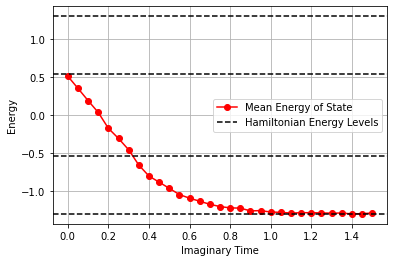

In [8]:
p1, = plt.plot(np.arange(0,N+1)*db, E, 'ro-')

w,v = get_spectrum(hm_list, nbits)
for energy_level in w:
    p2 = plt.axhline(y=energy_level, color='k', linestyle='--')

plt.legend((p1,p2), ('Mean Energy of State', 'Hamiltonian Energy Levels'),loc='best')

plt.xlabel('Imaginary Time')
plt.ylabel('Energy')
plt.grid()

plt.savefig(fig_path+run_identifier)
plt.show()